### Import packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn.functional as F

## Dataset And Dataloader

In [2]:
class TemporalDataset(Dataset):
    def __init__(self, features, labels, sequence_length):
        self.features = features
        self.labels = labels
        self.sequence_length = sequence_length
        self.max_length = len(features)

    def __len__(self):
        return len(self.features) - self.sequence_length + 1

    def __getitem__(self, idx):
        idx_end = idx + self.sequence_length

        # Extract the sequence of features
        sequence_features = self.features[idx:idx_end]

        # Handle NaN values: replace NaNs with zeros or any other strategy
        sequence_features = torch.tensor(sequence_features, dtype=torch.float32)
        sequence_features[torch.isnan(sequence_features)] = 0.0

        # Extract the label
        label = torch.tensor(self.labels[idx_end - 1], dtype=torch.long)

        return sequence_features, label


# File paths for training, validation, and testing
train_file = "D:/iMobie/Final Project/final test of LEGO CAR assambly/TRAINING ON ONLY RIGHT HAND DATA/concatenated_data_one_hot_train.csv"
test_file  = "D:/iMobie/Final Project/final test of LEGO CAR assambly/TRAINING ON ONLY RIGHT HAND DATA/concatenated_data_one_hot_test.csv"
val_file = "D:/iMobie/Final Project/final test of LEGO CAR assambly/TRAINING ON ONLY RIGHT HAND DATA/concatenated_data_one_hot_val.csv"

# Sequence length for creating sequences
sequence_length = 30  # You can adjust this based on your preference

# Read CSV files
train_data = pd.read_csv(train_file)
val_data = pd.read_csv(val_file)
test_data = pd.read_csv(test_file)

# Specify columns to normalize
columns_to_normalize = ['RotationRate',	'HorizontalRate',	'VerticalRate'	,'DuctionRate'	,'FlexionRate',	'StrengthAmplitude']  # Replace with your actual column names

# Normalize selected columns using StandardScaler
scaler = StandardScaler()
train_data[columns_to_normalize] = scaler.fit_transform(train_data[columns_to_normalize])
val_data[columns_to_normalize] = scaler.transform(val_data[columns_to_normalize])
test_data[columns_to_normalize] = scaler.transform(test_data[columns_to_normalize])

# Extract features and labels
train_features = train_data.drop(['temporal_order', 'action'], axis=1).values
train_labels = train_data['action'].values

val_features = val_data.drop(['temporal_order', 'action'], axis=1).values
val_labels = val_data['action'].values

test_features = test_data.drop(['temporal_order', 'action'], axis=1).values
test_labels = test_data['action'].values

# Use LabelEncoder to convert string labels to numerical labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

# Create datasets
train_dataset = TemporalDataset(train_features, train_labels, sequence_length)
val_dataset = TemporalDataset(val_features, val_labels, sequence_length)
test_dataset = TemporalDataset(test_features, test_labels, sequence_length)

# Batch size for the data loader
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print a sample from the training DataLoader
for batch_idx, (inputs, labels) in enumerate(train_loader):
    # Print the content of the first batch
    if batch_idx == 0:
        print(f"Batch {batch_idx + 1} - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
        for i in range(min(5, batch_size)):  # Print only the first 5 samples
            print(f"Sample {i + 1}: {inputs[i]}, Label: {labels[i]}")

    # Break out of the loop after printing the first batch
    break


Batch 1 - Inputs shape: torch.Size([32, 30, 42]), Labels shape: torch.Size([32])
Sample 1: tensor([[ 1.0986,  0.1220,  0.0982,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.1329, -0.1166,  0.1724,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.1626,  0.0693,  0.2540,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 1.8664,  0.0568,  0.0948,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.8934,  0.2733,  0.2849,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.9211,  0.5490,  0.3614,  ...,  0.0000,  0.0000,  0.0000]]), Label: 6
Sample 2: tensor([[ 2.8156e+01,  2.0568e-03, -3.6470e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.8181e+01,  2.0568e-03, -3.6470e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.8200e+01,  6.2354e-03, -5.6302e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 2.8911e+01,  4.1461e-03, -1.2117e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.8946e+01,  4.1461e

## LSTM Model

Epoch 1/500, Batch 1/4457, Loss: 1.9452885389328003
Epoch 1/500, Batch 101/4457, Loss: 1.511770248413086
Epoch 1/500, Batch 201/4457, Loss: 1.6238118410110474
Epoch 1/500, Batch 301/4457, Loss: 1.6018738746643066
Epoch 1/500, Batch 401/4457, Loss: 1.4780529737472534
Epoch 1/500, Batch 501/4457, Loss: 1.7905523777008057
Epoch 1/500, Batch 601/4457, Loss: 1.4674888849258423
Epoch 1/500, Batch 701/4457, Loss: 1.4750193357467651
Epoch 1/500, Batch 801/4457, Loss: 1.4313868284225464
Epoch 1/500, Batch 901/4457, Loss: 1.5046131610870361
Epoch 1/500, Batch 1001/4457, Loss: 1.3845384120941162
Epoch 1/500, Batch 1101/4457, Loss: 1.5730252265930176
Epoch 1/500, Batch 1201/4457, Loss: 1.3888025283813477
Epoch 1/500, Batch 1301/4457, Loss: 1.4867603778839111
Epoch 1/500, Batch 1401/4457, Loss: 1.4568594694137573
Epoch 1/500, Batch 1501/4457, Loss: 1.2936525344848633
Epoch 1/500, Batch 1601/4457, Loss: 1.3561383485794067
Epoch 1/500, Batch 1701/4457, Loss: 1.2691504955291748
Epoch 1/500, Batch 1801

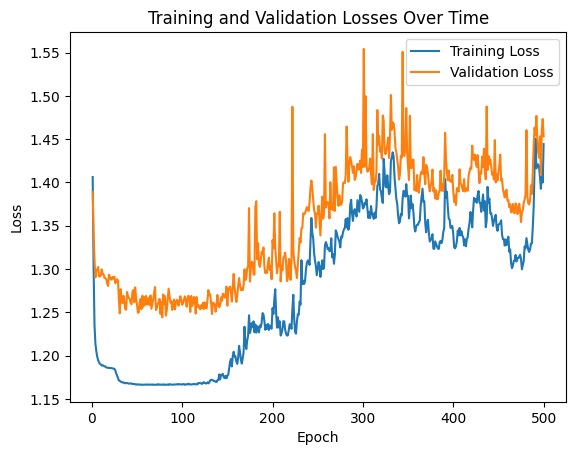

Test Accuracy: 69.69%


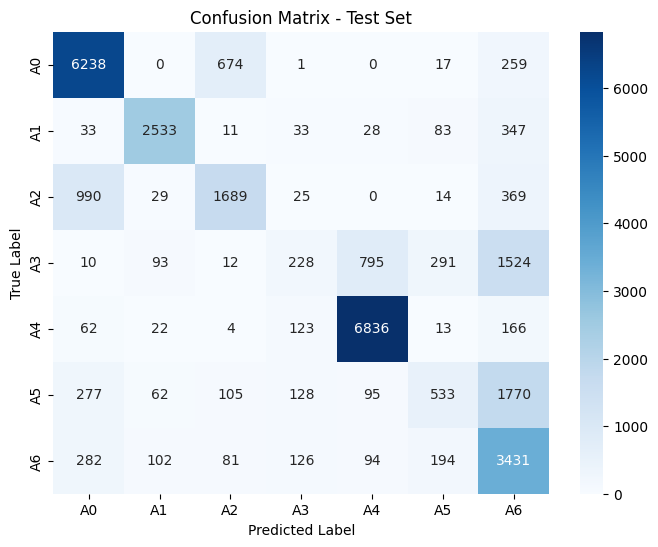

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # lstm_out: [batch_size, seq_len, hidden_size]

        # Attention mechanism
        attn_weights = torch.tanh(self.attention(lstm_out))  # [batch_size, seq_len, 1]
        attn_weights = torch.softmax(attn_weights, dim=1)    # [batch_size, seq_len, 1]
        attn_out = lstm_out * attn_weights                   # [batch_size, seq_len, hidden_size]
        attn_out = torch.sum(attn_out, dim=1)                # [batch_size, hidden_size]

        # Fully connected layer and softmax
        out = self.fc(attn_out)  # [batch_size, output_size]
        out = self.softmax(out)  # [batch_size, output_size]
        return out

# Assuming you have defined train_loader, val_loader, test_loader, train_features, label_encoder, etc.

# Set the input size, hidden size, number of layers, and output size
input_size = train_features.shape[1]
hidden_size = 128  # Increase the hidden size
num_layers = 2
output_size = len(label_encoder.classes_)

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of training epochs
num_epochs = 500

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}")

    # Calculate and store the average training loss for the epoch
    avg_train_loss = np.mean(epoch_train_losses)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    with torch.no_grad():
        epoch_val_losses = []
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            epoch_val_losses.append(val_loss.item())

        # Calculate and store the average validation loss for the epoch
        avg_val_loss = np.mean(epoch_val_losses)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss}")

# Save the trained model and label encoder
torch.save(model.state_dict(), './model.pth')
torch.save(label_encoder.classes_, './encoder.pth')

# Plot training and validation losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Time')
plt.legend()
plt.show()

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect predictions and labels for confusion matrix
        all_predictions.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix for the test set
conf_matrix_test = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
